In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
logging.basicConfig(level=logging.DEBUG)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

import pyglstudy as gl
from pyglstudy.group_lasso import *
from pyglstudy.group_basil import group_basil
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from tqdm import tqdm

In [3]:
def analyze_base(diag):
    logging.debug(f"Time Init:          {diag['time_init'][0]}")
    logging.debug(f"Time Init Fit:      {diag['time_init_fit'][0]}")
    logging.debug(f"Time Screen:        {np.sum(diag['time_screen'])}")
    logging.debug(f"Time Fit:           {np.sum(diag['time_fit'])}")
    logging.debug(f"Time KKT:           {np.sum(diag['time_kkt'])}")
    logging.debug(f"Time Transform:     {diag['time_transform'][0]}")
    logging.debug(f"Time Untransform:   {diag['time_untransform'][0]}")

def analyze_cov(diag):
    analyze_base(diag)
    
    time_gls = diag['time_group_lasso']
    types = ['time_strong_cd', 'time_active_cd', 'time_active_grad']
    titles = ['Strong CD Time', 'Active CD Time', 'Active Gradient Update Time']

    fig, axes = plt.subplots(1, len(types), layout='constrained', figsize=(10,4))
    for j in range(len(axes)):
        ax = axes[j]
        type_j = types[j]
        for i in tqdm(range(len(time_gls))):
            ax.plot(time_gls[i][type_j], alpha=0.7)
            ax.set_title(titles[j])
            ax.set_xlabel("CD Iteration")
            ax.set_ylabel("Time (s)")
    plt.show()
    
def analyze_naive(diag):
    analyze_base(diag)

    time_gls = diag['time_group_lasso']
    types = ['time_strong_cd', 'time_active_cd']
    titles = ['Strong CD Time', 'Active CD Time']

    fig, axes = plt.subplots(1, len(types), layout='constrained', figsize=(10,4))
    for j in range(len(axes)):
        ax = axes[j]
        type_j = types[j]
        for i in tqdm(range(len(time_gls))):
            ax.plot(time_gls[i][type_j], alpha=0.7)
            ax.set_title(titles[j])
            ax.set_xlabel("CD Iteration")
            ax.set_ylabel("Time (s)")
    plt.show()

In [29]:
n = 100000
p = 1000
n_groups = int(p/10)
seed = 0

np.random.seed(seed)
X, beta, y, groups, group_sizes = generate_group_lasso_data(
    n, p, n_groups, rho=0.7, svd_transform=False
).values()

In [ ]:
# cov
out_cov = group_basil(X, y, groups, group_sizes, method='cov', max_n_cds=int(5e6))

In [30]:
# naive
out_naive = group_basil(X, y, groups, group_sizes, method='naive', max_n_cds=int(5e6))
diag_naive = out_naive['diagnostic']

DEBUG:root:Time Init:          0.026487051
DEBUG:root:Time Init Fit:      0.025876267
DEBUG:root:Time Screen:        8.016e-05
DEBUG:root:Time Fit:           127.45115214500001
DEBUG:root:Time KKT:           1.220505567
DEBUG:root:Time Transform:     3.4288682350000004
DEBUG:root:Time Untransform:   0.003578014
100%|██████████| 11/11 [00:00<00:00, 1802.87it/s]


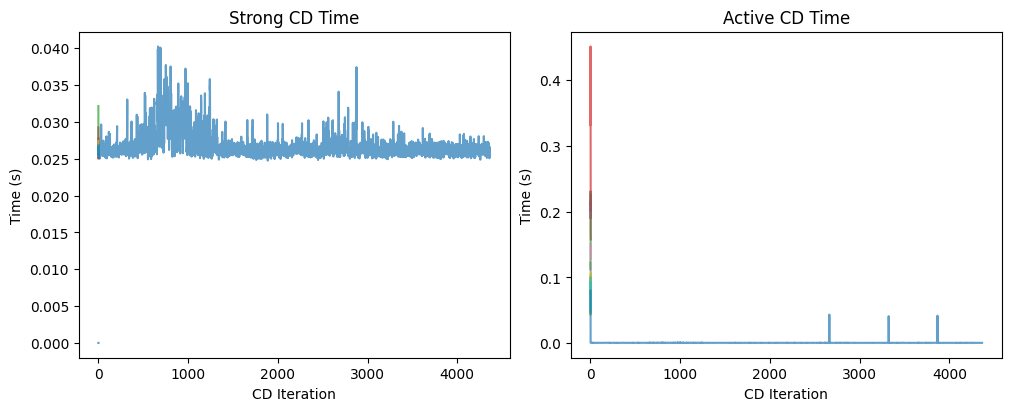

In [31]:
analyze_naive(diag_naive)

In [32]:
len(out_naive['rsqs'])

51

In [33]:
out = out_naive
out['betas'], out['error']

(<1000x51 sparse matrix of type '<class 'numpy.float64'>'
 	with 153 stored elements in Compressed Sparse Column format>,
 '')

100%|██████████| 1000/1000 [00:00<00:00, 2036.51it/s]


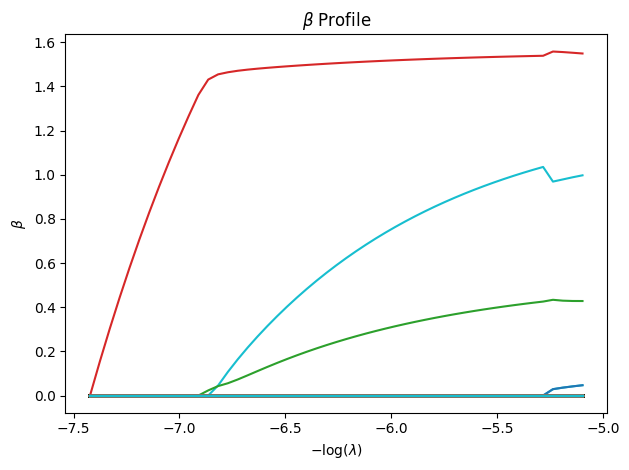

In [34]:
for j in tqdm(range(out['betas'].shape[0])):
    if j % 1 == 0:
        plt.plot(-np.log(out['lmdas']), out['betas'][j].todense().reshape((-1,1)))
plt.title('$\\beta$ Profile')
plt.xlabel('$-\log(\lambda)$')
plt.ylabel('$\\beta$')
plt.tight_layout()
plt.show()

In [ ]:
def run_cvxpy(X, y, groups, group_sizes, alpha, penalty, lmda):
    _, p = X.shape
    beta = cp.Variable(p)
    regul = 0
    for i in range(len(groups)):
        gb = groups[i]
        ge = gb + group_sizes[i]
        bi_norm2 = cp.norm2(beta[gb:ge])
        regul += penalty[i] * (alpha * bi_norm2 + (1-alpha) / 2 * cp.sum_squares(beta[gb:ge]))
    objective = cp.Minimize(0.5 * cp.sum_squares(y - X @ beta) + lmda * regul)
    prob = cp.Problem(objective)
    result = prob.solve()
    return beta.value 


In [ ]:
lmdas = np.array(out['lmdas'])
cvxpy_betas = np.empty((p, len(lmdas)))
for i in tqdm(range(len(lmdas))):
    cvxpy_betas[:, i] = run_cvxpy(X, y, groups, group_sizes, alpha=1, penalty=np.sqrt(group_sizes), lmda=lmdas[i])

In [ ]:
for j in range(cvxpy_betas.shape[0]):
    if j % (10) == 0:
        plt.plot(-np.log(out['lmdas']), cvxpy_betas[j])
plt.title('$\\beta$ Profile')
plt.xlabel('$-\log(\lambda)$')
plt.ylabel('$\\beta$')
plt.tight_layout()
plt.show()